## Step 1: Library import

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.model_selection import GridSearchCV

import xray_data #y data: 1 = NORMAL, 0 = PNEUMONIA


## Step: Load and preprocess data
Note: data is resized and preprocessed as read, as a memory optimization.

In [4]:
#Constants
scale = 200
label_filter = ['NORMAL','PNEUMONIA','COVID19','TURBERCULOSIS']

In [5]:
# X_dev_orig, y_dev_orig = xray_data.load_dev(scale,label_filter)
# print(f'X_dev_orig, y_dev_orig shape: {X_dev_orig.shape, y_dev_orig.shape}')
# print(f'y_dev_orig shape for NORMAL cases: {y_dev_orig[y_dev_orig ==1].shape}')
# print('----')

In [6]:
# cut of for training samples of each class, only 230 normal rows
test_cutoff = 230

X_test, y_test = xray_data.load_test(scale,label_filter,test_cutoff, subset = 'PROP')
print(f'X_test, y_test shape: {X_test.shape, y_test.shape}')
print(f'y_test shape for NORMAL cases: {y_test[y_test ==1].shape}')
print('----')

100% (106 of 106) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (390 of 390) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (234 of 234) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (41 of 41) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


COVID19: 31
PNEUMONIA: 116
NORMAL: 69
TURBERCULOSIS: 12
Total: 228
X_test, y_test shape: ((228, 40000), (228,))
y_test shape for NORMAL cases: (116,)
----


In [7]:
# cut of for training samples of each class, only 1300 normal rows
train_cutoff = 1300

X_train, y_train = xray_data.load_train(scale,label_filter,subset = 'PROP')

100% (460 of 460) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
100% (3875 of 3875) |####################| Elapsed Time: 0:00:37 Time:  0:00:37
100% (1341 of 1341) |####################| Elapsed Time: 0:00:31 Time:  0:00:31
100% (650 of 650) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


COVID19: 460
PNEUMONIA: 3875
NORMAL: 1341
TURBERCULOSIS: 650
Total: 6326


In [17]:
# I'm not sure what the final stratify parameter is doing.  We'll want to revist when we do full cross validation

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size = .2, stratify = y_train, random_state = 207 )
print(f'X_train, y_train shape: {X_train.shape, y_train.shape}')
print(f'y_train shape for NORMAL cases: {y_train[y_train ==1].shape}')
print('----')
print(f'X_dev, y_dev shape: {X_dev.shape, y_dev.shape}')
print(f'y_dev shape for NORMAL cases: {y_dev[y_dev ==1].shape}')

X_train, y_train shape: ((2530, 40000), (2530,))
y_train shape for NORMAL cases: (1549,)
----
X_dev, y_dev shape: ((633, 40000), (633,))
y_dev shape for NORMAL cases: (388,)


## Single Model training

In [18]:
NB1 = MultinomialNB()
NB1.fit(X_train, y_train)
NB1.score(X_dev, y_dev)

0.6966824644549763

##  Multiple Model with For Loop

In [23]:
alphas = np.arange(70,110,1)
scores = []
for i in alphas:
    NB2 = MultinomialNB(alpha = i)
    NB2.fit(X_train, y_train)
    scores.append(NB2.score(X_dev, y_dev))


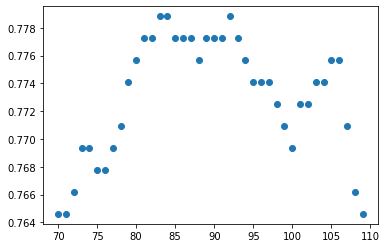

In [24]:
plt.scatter(alphas, scores)

## Gridsearch model

In [29]:
NB = MultinomialNB()

param_grid = [
    {
        'alpha': alphas
    }
]

NB_gscv = GridSearchCV(NB, param_grid, cv=5, verbose=1)
NB_gscv.fit(X_train,y_train) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.7min finished


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid=[{'alpha': array([ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109])}],
             verbose=1)

In [30]:
print('Multinomial Naive Bayes Grid Search with 5-Fold Cross-Validation')
print('Best Score: %.3f' % NB_gscv.best_score_)
print('Optimal Parameters:') 
best_params = NB_gscv.best_params_
for param in best_params: 
    print('\t%s: %s' % (param, best_params[param]))

Multinomial Naive Bayes Grid Search with 5-Fold Cross-Validation
Best Score: 0.751
Optimal Parameters:
	alpha: 71


In [31]:
split_scores = []
for i in range(5):
#     print(f'split{i}_test_score')
    split_scores.append(NB_gscv.cv_results_[f'split{i}_test_score'])
split_scores = np.array(split_scores)
average_score = split_scores.mean(axis = 0)
max_score = split_scores.max(axis = 0)

Text(0, 0.5, 'Score')

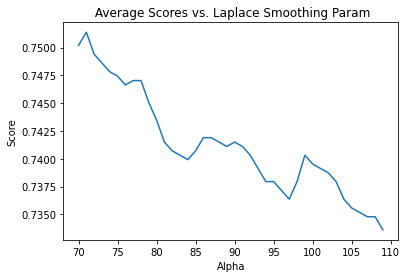

In [32]:
plt.plot(alphas, average_score)
plt.title(' Average Scores vs. Laplace Smoothing Param', size = 12)
plt.xlabel('Alpha')
plt.ylabel('Score')

Text(0, 0.5, 'Score')

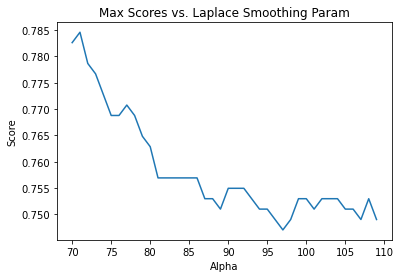

In [33]:
plt.plot(alphas, max_score)
plt.title('Max Scores vs. Laplace Smoothing Param', size = 12)
plt.xlabel('Alpha')
plt.ylabel('Score')